In [1]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
# from lightgbm import LGBMClassifier

s3 = boto3.resource('s3')
bucket_name = 'data-mining-cup'
bucket = s3.Bucket(bucket_name)

file_key_1 = 'dmc-2008/dmc2008_train.txt'
file_key_2 = 'dmc-2008/dmc2008_class.txt'

bucket_object_1 = bucket.Object(file_key_1)
file_object_1 = bucket_object_1.get()
file_content_stream_1 = file_object_1.get('Body')

bucket_object_2 = bucket.Object(file_key_2)
file_object_2 = bucket_object_2.get()
file_content_stream_2 = file_object_2.get('Body')

## Reading data-files
train = pd.read_csv(file_content_stream_1, sep = ';')
test = pd.read_csv(file_content_stream_2, sep = ';')

train.head()

,id,target,Neukunde,AUFNAHME_LOTTERIE,TEL_ART,BANKART,WERBEWEG,GESCHLECHT,KUNDEN_ALTER,ALTERSDEZIL,KAUFKRAFTDEZIL,ERS_LOS_AUFN,SERVICEWEG_AUF,ZAHLUNGSWEG_AUF,ANZ_GESPIELTE_LOTTERIEN,ZBEST_VOL_t1,KKI_INFO_LOTTERIE_VORLOT,KKI_REKLAMATION_LOTT_VORLOT,HGEW,MTKAUG,MTSTAG,MTSTRG,MTBEBG,MTAUSG,MTALTG,MTAJUG,MTAALG,MTFAMG,MTMMOG,MTBONG,MTPOZG,MTWIZG,MTTING,MSBKRG,MSBRKG,klv_scr,tec_scr,ifi_scr,eih_scr,eiw_scr,mtpvvg,mtpzvg,MTKDIG,MTKLEG,MTKKLG,MTKGBG,MTKGLG,MTKPRG,MTKSPG,MTKJAG,MTKDSG,MTKGEG,MTKEMG,MTKOEG,MTKK1K,MTK01G,MTK02G,MTK03G,MTK04G,MTK05G,MTK06G,MTK07G,MTK08G,MTK09G,MTK10G,MTK11G,MTK12G,MTK13G,MTK14G,ablnbl,regio
0,178259,0,0,117,1,10,6,1,54,7,8,2,2,1,5,"0,924308582887685",1,0,0.0,-4.0,3.0,1.0,3.0,3.0,4.0,8.0,7.0,1.0,4.0,8.0,9.0,9.0,3.0,5.0,5.0,5.0,4.0,5.0,5.0,6.0,3.0,3.0,1.0,7.0,6.0,2.0,0.0,0.0,0.0,2.0,1.0,0.0,5.0,0.0,2.0,0.0,5.0,4.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,98.0,12.0
1,133003,3,1,121,1,12,6,3,46,5,5,2,2,1,1,"-0,292245009765242",0,0,0.0,4.0,6.0,1.0,1.0,2.0,3.0,7.0,5.0,6.0,9.0,3.0,6.0,6.0,5.0,5.0,6.0,2.0,3.0,1.0,2.0,2.0,4.0,5.0,6.0,5.0,6.0,8.0,0.0,2.0,0.0,3.0,9.0,0.0,6.0,2.0,6.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,0.0,1.0,1.0,2.0,0.0,98.0,23.0
2,12054,4,0,115,1,16,6,1,49,6,8,2,2,1,7,"-0,596383407928474",0,0,0.0,2.0,7.0,1.0,1.0,1.0,4.0,4.0,3.0,6.0,4.0,3.0,3.0,3.0,7.0,7.0,1.0,2.0,2.0,2.0,3.0,3.0,8.0,9.0,7.0,4.0,5.0,3.0,2.0,2.0,0.0,3.0,6.0,0.0,6.0,0.0,6.0,1.0,2.0,1.0,3.0,0.0,3.0,2.0,1.0,2.0,1.0,1.0,1.0,2.0,0.0,98.0,12.0
3,87384,4,0,105,1,16,7,1,53,7,9,1,2,1,17,"1,83672377737738",0,0,1.0,4.0,8.0,2.0,1.0,2.0,4.0,5.0,5.0,5.0,6.0,3.0,6.0,2.0,8.0,7.0,1.0,4.0,1.0,3.0,4.0,2.0,9.0,9.0,4.0,6.0,6.0,5.0,3.0,0.0,0.0,3.0,9.0,1.0,7.0,0.0,6.0,2.0,5.0,1.0,2.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,3.0,0.0,98.0,22.0
4,130245,4,0,104,1,4,7,1,79,10,3,3,2,1,18,"0,0118933883979897",0,0,0.0,2.0,6.0,1.0,1.0,3.0,7.0,2.0,9.0,5.0,4.0,4.0,5.0,2.0,2.0,5.0,4.0,3.0,5.0,3.0,2.0,3.0,7.0,6.0,6.0,5.0,7.0,3.0,0.0,0.0,0.0,2.0,4.0,0.0,6.0,0.0,6.0,2.0,2.0,2.0,3.0,2.0,2.0,4.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,98.0,34.0


In [2]:
train.shape

(113476, 71)

In [4]:
train['target'].value_counts() / train.shape[0]

4    0.462750
0    0.238764
3    0.142894
2    0.088433
1    0.067160
Name: target, dtype: float64

In [12]:
a = pd.crosstab(train['target'], train['Neukunde'])
a.shape

(5, 2)

In [13]:
a

Neukunde,0,1
target,,
0,15920,11174
1,3587,4034
2,4536,5499
3,6106,10109
4,42088,10423


In [14]:
a.index

Int64Index([0, 1, 2, 3, 4], dtype='int64', name='target')

<AxesSubplot:xlabel='target'>

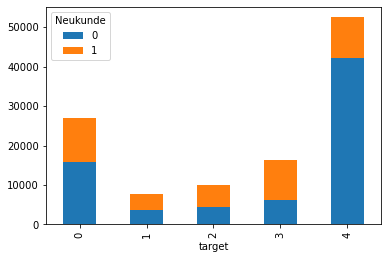

In [16]:
a.plot(kind = 'bar', stacked = True)

<AxesSubplot:xlabel='target'>

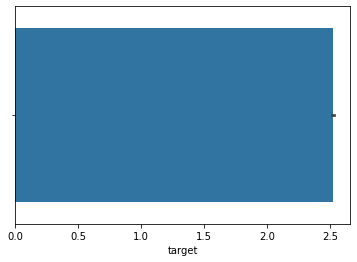

In [8]:
sns.barplot(x = 'target', data = train)